<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/nlp/spanish_english_seq2seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention is all you need

**Resources**

* [Lilian Weng's Blog](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
* [Guillaume Genthial blog](https://guillaumegenthial.github.io/sequence-to-sequence.html)
* [Machine Learning Mastery](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/) 

Attention Mechanisms in Neural Networks are (very) loosely based on the visual attention mechanism found in humans

**Issues with Seq2Seq Models**

![seq-2-seq](https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png)

* Unable to capture long term dependencies. Long-range dependencies still tricky despite of gating models like LSTMs and GRUs.
* Handle input sequence word by word.
* In translation systems, only the last hidden state is passed to the decoder, but it is not good enough to capture all the information pertaining to translation.

> You can’t cram the meaning of a whole %&! # sentence into a single &!#* vector!

In an attention mechanism, we do not encode the entire sequence into a single vector, rather allow decoder to attend to different parts of the source sentence at each step of the output generation. 

Each decoder output word depends on a weighted combination of all the input states, not just the last state. Attention allows us to interpret and visualise what the model is doing as heatmaps. 

## DECODER

Rather than building a single context vector out of the encoder’s last hidden state, attention adds shortcuts between the context vector and the entire source input. The weights of these shortcut connections are customizable for each output element. 

Consider, source sequence `x` of length `n` and target sequence `y` of length `m` 

\begin{aligned}
\mathbf{x} &= [x_1, x_2, \dots, x_n] \\
\mathbf{y} &= [y_1, y_2, \dots, y_m]
\end{aligned}

Encoder produces hiddent state $h_{i}$ for each input timestep. The decoder has hidden state, 
$s_{t}=f(s_{t-1}, y_{t-1}, c_{t})$ for $t=1, ..., m$, where

\begin{aligned}
\mathbf{c}_t &= \sum_{i=1}^n \alpha_{t,i} \boldsymbol{h}_i & \small{\text{; Context vector for output }y_t}\\
\alpha_{t,i} &= \text{align}(y_t, x_i) & \small{\text{; How well two words }y_t\text{ and }x_i\text{ are aligned.}}\\
&= \frac{\exp(\text{score}(\boldsymbol{s}_{t-1}, \boldsymbol{h}_i))}{\sum_{i'=1}^n \exp(\text{score}(\boldsymbol{s}_{t-1}, \boldsymbol{h}_{i'}))} & \small{\text{; Softmax of some predefined alignment score.}}.
\end{aligned}


$\alpha_{t,i}$ is the score for the input at position $i$ and output at position $t$ i.e for the pair $(y_{t}, x_{i})$

In the diagram below - 
* f - score function
* g - dense layer

![Attention](https://guillaumegenthial.github.io/assets/img2latex/seq2seq_attention_mechanism_new.svg)

### Bahdanau

$$score(s_t, h_i) = {v}_a^\top \tanh({W}_a[s_t;h_i])$$
where both $v_a$ and $W_a$ are weight matrices to be learned in the alignment model.

**Pseudo Code**
```python
1. score = dense[tanh(dense(encoder_output) + dense(decoder_hidden_state))]
2. attention_weights = softmax(score, axis=1)
3. context_vector = sum(attention_weights*encoder_output, axis=1)
4. dec_embedding = embedding(decoder_input)
5. merged_vector = concat(dec_embedding, context_vector)
6. decoder_output, decoder_hidden_states = LSTM(merged_vector)
```

### Luong

$$score(s_t, h_i) = s_t^\top\mathbf{W}_a{h}_i$$
where $W_a$ is a trainable weight matrix in the attention layer.

Decoder RNN gives only the hidden state vector, which is used to calculate the *output vector*, as well as combined with the context vector to pass as input to the next decoder unit. 

##  TEACHER FORCING

There are sequence prediction models that use the output from the last time step `y(t-1)` as input for the model at the current time step `X(t)`. They can suffer from the following problem - 
* Slow convergence.
* Model instability.
* Poor skill

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input. It works by using the actual or expected output from the training dataset at the current time step `y(t)` as input in the next time step `X(t+1)`, rather than the output generated by the network.

![img](https://guillaumegenthial.github.io/assets/img2latex/img2latex_training.svg)

## Dataset
English to Spanish Conversion - http://www.manythings.org/anki/spa-eng.zip

In [0]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2020-04-20 15:03:23--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.56M  15.8MB/s    in 0.3s    

2020-04-20 15:03:24 (15.8 MB/s) - ‘spa-eng.zip’ saved [4781548/4781548]



In [0]:
!unzip -l spa-eng.zip
!unzip spa-eng.zip

Archive:  spa-eng.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     1441  2020-03-15 02:17   _about.txt
 18493172  2020-03-15 02:17   spa.txt
---------                     -------
 18494613                     2 files
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [0]:
from collections import Counter
from google.colab import files
import matplotlib.pyplot as plt
from itertools import islice
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import seaborn as sns
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

In [0]:
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
disable_eager_execution()

Disabling eager execution because all zeros mask raises some CuDNN kernel level issue. Refere [here](https://github.com/tensorflow/tensorflow/issues/33148)

In [0]:
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
lines = pd.read_table('spa.txt', names=['english', 'spanish', 'attributes'])
# lines = pd.DataFrame({"english": ["Juan eats apples"], "spanish": ["Juan come manzanas"], "attributes": ""})

In [0]:
lines.shape

(123770, 3)

In [0]:
lines = lines.drop(columns=['attributes'])

In [0]:
for col in lines.columns:
    # lowercase
    lines[col] = lines[col].apply(lambda x: x.lower())
    # remove quotes
    lines[col] = lines[col].apply(lambda x: re.sub("'", "", x))
    # remove punctuations
    lines[col] = lines[col].apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    # remove numbers
    remove_digits = str.maketrans('', '', digits)
    lines[col] = lines[col].apply(lambda x: x.translate(remove_digits))
    # remove unnecessary spaces
    lines[col] = lines[col].apply(lambda x: x.strip())
    lines[col] = lines[col].apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences
lines['spanish'] = lines['spanish'].apply(lambda x : 'START_ '+ x + ' _END')

In [0]:
pd.set_option('display.max_colwidth', 100)

In [0]:
lines.head(10)

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END
5,run,START_ ¡corre _END
6,run,START_ ¡corran _END
7,run,START_ ¡corra _END
8,run,START_ ¡corred _END
9,run,START_ corred _END


## Creating Vocabulary
Create vocabulary of english and spanish words

In [0]:
# English Vocab
all_eng_words = set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
print(f"English Vocab: {len(all_eng_words)}")

English Vocab: 13475


In [0]:
# Spanish Vocab
all_spa_words = set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)
print(f"Spanish Vocab: {len(all_spa_words)}")

Spanish Vocab: 27264


In [0]:
# Max Length of source sequence
lenght_list_eng=[]
for l in lines['english']:
    lenght_list_eng.append(len(l.split(' ')))
max_length_src = np.max(lenght_list_eng)
print(f"Max Length Sentence (English): {max_length_src}")

Max Length Sentence (English): 47


In [0]:
# Max Length of target sequence
lenght_list_spa=[]
for l in lines['spanish']:
    lenght_list_spa.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list_spa)
print(f"Max Length Sentence (Spanish): {max_length_src}")

Max Length Sentence (Spanish): 47


In [0]:
matches = [i for i, j in zip(lenght_list_eng, lenght_list_spa) if i == j]
print(f"Number of matches: {len(matches)} ({(len(matches)*100/lines.shape[0]):.2f})")

Number of matches: 13865 (11.20)


In [0]:
lines.head()

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END


In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)
num_encoder_tokens, num_decoder_tokens

(13475, 27264)

In [0]:
num_encoder_tokens += 1 # For zero padding
num_decoder_tokens += 1 # For zero padding

## Tokenization

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
n_items = take(10, input_token_index.items())
for k,v in n_items:
    print(k, v)

a 1
aardvark 2
aardvarks 3
aaron 4
aback 5
abandon 6
abandoned 7
abandoning 8
abate 9
abated 10


In [0]:
n_items = take(10, target_token_index.items())
for k,v in n_items:
    print(k, v)

START_ 1
_END 2
a 3
aabe 4
aah 5
aaron 6
abajo 7
abandona 8
abandonada 9
abandonadas 10


In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [0]:
lines = shuffle(lines)
lines.head(10)

,english,spanish
103365,in those days he lived in the house alone,START_ por aquel entonces vivía solo en la casa _END
120306,he doesnt like to wait until the last moment to do something,START_ a él no le gusta esperar hasta el último momento para hacer algo _END
59768,i thought i was going to die,START_ pensé que iba a morir _END
36329,you need to talk to me,START_ necesitas que hablemos de tú a tú _END
109374,have you ever heard someone speaking in french,START_ ¿alguna vez escuchaste a alguien hablando francés _END
116537,im afraid that we wont be able to help you tomorrow,START_ me temo que no podremos ayudarte mañana _END
41279,he acts like a tough guy,START_ se las da de guapo _END
5961,do you want it,START_ ¿lo quieres _END
31701,you cant run my life,START_ no puedes gobernar mi vida _END
1267,ill do it,START_ lo haré _END


## Train-Test Split

In [0]:
X, y = lines["english"], lines["spanish"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
X_train.shape, y_train.shape

((99016,), (99016,))

In [0]:
X_test.shape, y_test.shape

((24754,), (24754,))

## Generator

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Teacher Forcing
Teacher forcing works by using the actual or expected output from the training dataset at the current time step `y(t)` as input in the next time step `X(t+1)`, rather than the output generated by the network.

Decoder is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Effectively, the decoder learns to generate targets `[t+1...]` given targets `[...t]`, conditioned on the input sequence.


### Example - 
Suppose, we had only 1 sentence -
* `English` - Juan eats apples
* `Spanish` - Juan come manzanas

Hence, we had just 3 words in our English & 5 in Spanish vocabulary. 
```
English Vocabulary
{'apples': 1, 'eats': 2, 'juan': 3}

Spanish Vocabulary
{'START_': 1, '_END': 2, 'come': 3, 'juan': 4, 'manzanas': 5}
```

So our encoded input & decoder input would look like - 
```
Encoder Input Data: [[3. 2. 1.]]

Decoder Input Data: [[1. 4. 3. 5. 0.]]
```

As the target sentence has 5 words, at timestep `t` during training, we set the previous timestep's `t-1` actual output to 1. So essentially, we will have 5 target sentence.

```
Decoder Target Data: 
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # come
[0. 0. 0. 0. 0. 1.] # manzanas
[0. 0. 1. 0. 0. 0.] # _END
[0. 0. 0. 0. 0. 0.]
```

### Summary
TS1 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 1. 0.] # juan
```

TS2 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 1. 0. 0.] # juan come
```

TS3 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 0. 1.] # juan come manzanas
```

TS4 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 1. 0. 0. 0. 0.] # juan come manzanas _END
```


## Bahdanau Attention

For a single sequence - 
* `query` - Current target hidden state. Size - `(hidden_size)`
* `values` - All the encoder hidden states. Size -  `(max_len, hidden size)`
* `attention_weights` - A single vector with weights for each hidden state. As there are `max_len` units in the encoder LSTM, it's size will be `(max_len)` 
* `context_vector` - Weighted sum of encoder hidden states. Size - `(hidden_size)`

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query (decoder hidden state) ==> (batch_size, hidden size)
    # query_with_time_axis ==> (batch_size, 1, hidden size)
    # values (encoder outputs) ==> (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score ==> (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights ==> (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector ==> (batch_size, max_length, hidden_size)
    context_vector = attention_weights * values
    # context_vector ==> (batch_size, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## Model

In [0]:
latent_dim = 100

In [0]:
# ENCODER
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

`mask_zero=True` - It treats '0' as a padding value. Notice that we haven't explicitly padded sequneces to lenght `max_len`. As per the docs, 
>"If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1)". 

Which is why increased `num_encoder_tokens` & `num_decoder_tokens` in cell 20 

In [0]:
# DECODER
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

attention_layer = BahdanauAttention(latent_dim)
context_vector, attention_weights = attention_layer(encoder_outputs, state_h)
merged_vector = tf.concat([tf.expand_dims(context_vector, 1), dec_emb], axis=-1)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# set up the decoder, using `encoder_states` as initial state
decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(dec_emb, 
                                                         initial_state=encoder_states)

In [0]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Here, we add a Dense Layer that uses softmax activation on top of decoder. Notice, how for the sample sentence - `Juan eats apples`, the output target at each timestep looks like - 
```
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # juan come
[0. 0. 0. 0. 0. 1.] # juan come manzanas
[0. 1. 0. 0. 0. 0.] # juan come manzanas _end
```
It is the job of the dense layer to predict this next word from the *decoder_outputs*

Model will take encoder inputs & decoder inputs and return decoder outputs

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

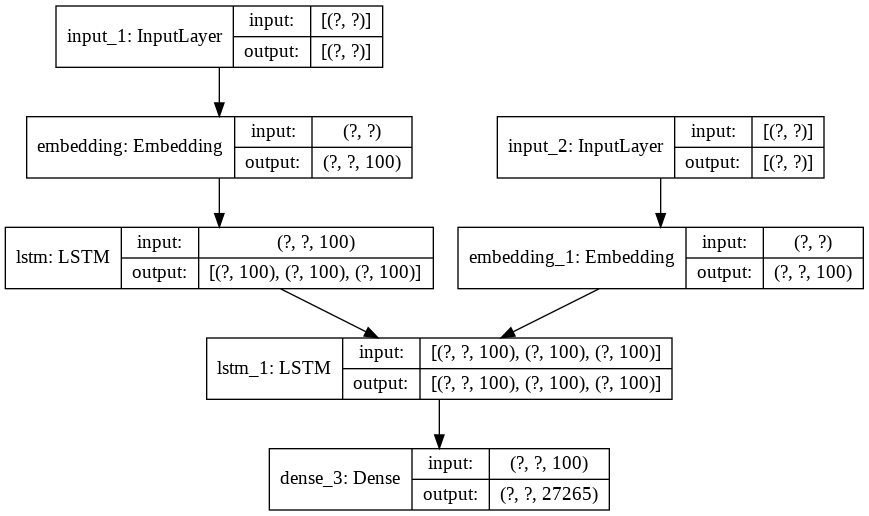

In [0]:
plot_model(model, show_shapes=True)

## Training

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 20

In [0]:
csvlogger = CSVLogger("training.log")
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callbacks = [csvlogger, earlystopping]

In [41]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=callbacks
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
773/773 [==============================] - 738s 955ms/step - loss: 0.8475 - acc: 0.1650 - val_loss: 0.7579 - val_acc: 0.2016
Epoch 2/20
773/773 [==============================] - 739s 955ms/step - loss: 0.6987 - acc: 0.2436 - val_loss: 0.6576 - val_acc: 0.2795
Epoch 3/20
773/773 [==============================] - 741s 959ms/step - loss: 0.6151 - acc: 0.3054 - val_loss: 0.5989 - val_acc: 0.3265
Epoch 4/20
773/773 [==============================] - 740s 957ms/step - loss: 0.5546 - acc: 0.3542 - val_loss: 0.5537 - val_acc: 0.3654
Epoch 5/20
773/773 [==============================] - 736s 952ms/step - loss: 0.5064 - acc: 0.3933 - val_loss: 0.5187 - val_acc: 0.3942
Epoch 6/20
773/773 [==============================] - 740s 957ms/step - loss: 0.4666 - acc: 0.4249 - val_loss: 0.4919 - val_acc: 0.4177
Epoch 7/20
773/773 [==============================] - 746s 965ms/step - loss: 0.4327 - acc: 0.4528 - val_los

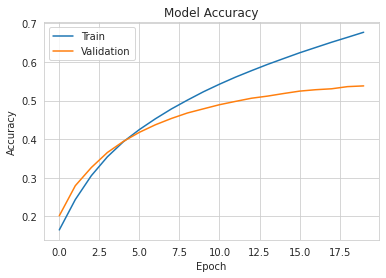

In [42]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

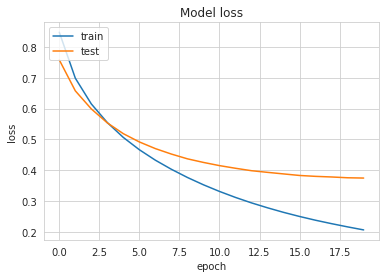

In [43]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save("english_to_spanish_attention_nmt.h5")

In [0]:
model = load_model("english_to_spanish_attention_nmt.h5")

In [0]:
files.download("english_to_spanish_attention_nmt.h5")

## Inference

***Encoder Setup***

Encode the input sequence to get the encoder_states - `state_h & state_c`

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

***Decoder setup***

Below tensors will hold the states of the previous time step. In case of the first sequence, assume - 
>1. decoder_state_input_c - state_c
>2. decoder_state_input_h - state_h


In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Get the embedding of decoder output sequences. For the first sequence, it will return the embedded vector for `START_` - [1., 0., 0., 0., 0.]. If the next predicted word is Juan, it will then return the embedded vector for `Juan` - [0., 0., 0., 1., 0.]

In [0]:
dec_emb2 = dec_emb_layer(decoder_inputs)

context_vector, attention_weights = attention_layer(encoder_outputs, 
                                                    decoder_state_input_h)
merged_vector = tf.concat([tf.expand_dims(context_vector, 1), dec_emb2], 
                          axis=-1)

To predict the next word in the sequence, set the initial states to the states from the previous time step


In [0]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=decoder_states_inputs)

Predict the next word in the sequence using the dense layer and choose the most probable word by selecting the word with most probability from the softmax probability distribution.

In [0]:
decoder_outputs2 = decoder_dense(decoder_outputs2) 

***Final Decoder Model***

Inputs -
>1. decoder_inputs - List of word
>2. decoder_states_inputs - previous timestep's hidden state & cell state

Outputs - 
>1. decoder_outputs2 - one-hot vector represeting the predicted word 
>2. decoder_states2 - current timestep's hidden state & cell state

In [0]:
decoder_states2 = [state_h2, state_c2]
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

## Decode Sequence

In [0]:
# https://github.com/numpy/numpy/issues/15201#issue-543733072

def categorical(p):
    return (p.cumsum(-1) >= np.random.uniform(size=p.shape[:-1])[..., None]).argmax(-1)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sampling a token with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Sample from a categorical distribution
        # logits = output_tokens[0, -1, :]
        # sampled_token_index = categorical(np.reshape(logits, [-1, len(logits)]))[0]
         
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_length_tar):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

My attempt at using ***Beam Search Decoding*** using probabilites

In [0]:
def beam_search_decoder(predictions, top_k = 3):
    #start with an empty sequence with zero score
    output_sequences = [([], 0)]
    
    #looping through all the predictions
    for token_probs in predictions:
        new_sequences = []
        
        #append new tokens to old sequences and re-score
        for old_seq, old_score in output_sequences:
            for char_index in range(len(token_probs)):
                new_seq = old_seq + [char_index]
                #considering log-likelihood for scoring
                new_score = old_score + math.log(token_probs[char_index])
                new_sequences.append((new_seq, new_score))
                
        # sort all new sequences in the de-creasing order of their score
        output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
        
        #select top-k based on score 
        # *Note- best sequence is with the highest score
        output_sequences = output_sequences[:top_k]
        
    return output_sequences

In [0]:
def decode_sequence_beam_search(input_seq):
    probabilities = []
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sampling a token with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        probabilities.append(output_tokens[0, -1, :])
         
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_length_tar):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    # storing multiple results
    outputs = []
    beam_search_preds = beam_search_decoder(probabilities, top_k = 10)
    for prob_indexes, score in beam_search_preds:
        decoded_sentence = ''
        for index in prob_indexes:
            sampled_char = reverse_target_char_index[index]
            decoded_sentence += ' '+sampled_char
            if (sampled_char == '_END' or len(decoded_sentence) > max_length_tar):
                break
        outputs.append(decoded_sentence)

    return outputs

### Utility Function

Function that makes a request at [My Memory Translated](https://mymemory.translated.net/) to get back the English translation of predicted Spanish sentence.

In [0]:
url = "https://api.mymemory.translated.net/get"

def get_translation(seq):
    data = {}
    data["q"] = seq
    data["langpair"] = "es|en"
    response = requests.post(url, data=data)
    translated_text = response.json()["responseData"]["translatedText"]
    return translated_text

### White Distance

Metric to find similarity between two sentences

In [0]:
def upper_case(s):
    return s.upper()

def get_pairs(s):
    pairs = []
    words = s.strip().split(' ')
    for word in words:
        for idx in range(len(word)-1):
            pairs.append(word[idx:idx+2])
    return pairs

def get_similarity(s1, s2):
    s1 = upper_case(s1)
    s2 = upper_case(s2)
    p1 = get_pairs(s1)
    p2 = get_pairs(s2)
    nr = 2*len(list((Counter(p1) & Counter(p2)).elements()))
    dr = len(p1)+len(p2)
    return nr/dr

### Training Data

In [60]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1
for _ in range(30):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Translation (Spanish):', decoded_sentence[:-4])
    # predicted spanish sequence back to english
    print('Predicted Translation (English):', get_translation(decoded_sentence[:-4]))
    print("="*60, end="\n\n")

Input Sentence: tom is still baffled
Actual Translation:  tom está todavía confuso 
Predicted Translation (Spanish):  tom todavía está borracho 
Predicted Translation (English): tom is still drunk

Input Sentence: i think you were better looking with long hair
Actual Translation:  creo que estabas más guapo con el pelo largo 
Predicted Translation (Spanish):  creo que te ves con el gerente de estado muy ocup
Predicted Translation (English): I think you see the state manager very busy

Input Sentence: wont you speak to tom about it
Actual Translation:  ¿no hablaráis con tom al respecto 
Predicted Translation (Spanish):  ¿no te sientes a tom con algo de eso 
Predicted Translation (English): Don&#39;t you sit down tom with some of that

Input Sentence: tom is taller than i am
Actual Translation:  tom es más alto que yo 
Predicted Translation (Spanish):  tom es más alto que yo 
Predicted Translation (English): Tom is taller than I am.

Input Sentence: how long are you planning to stay here

In [61]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1
for _ in range(20):
    k+=1
    similarity_scores = []
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentences = decode_sequence_beam_search(input_seq)
    acutal_sentence = y_train[k:k+1].values[0][6:-4]
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', acutal_sentence)
    for idx, pred in enumerate(decoded_sentences):
        similarity_scores.append(get_similarity(pred, acutal_sentence))
    dictionary = dict(zip(similarity_scores, decoded_sentences))
    dictionary = {k: v for k, v in sorted(dictionary.items(), 
                                          key=lambda item: item[1], 
                                          reverse=True)}
    closest_sentence = decoded_sentences[np.argmax(similarity_scores)]
    print(f"Closest Predicted Sentence (Spanish): {closest_sentence[:-4]}")
    print(f"Closest Predicted Sentence (English): {get_translation(closest_sentence[:-4])}", end="\n\n")
    decoded_sentences.remove(closest_sentence)
    for idx, pred in enumerate(list(dictionary.values())[:5]):
        print(f'Predicted Translation {idx}: {pred[:-4]}')
    print("="*30, end="\n\n")

Input Sentence: tom is still baffled
Actual Translation:  tom está todavía confuso 
Closest Predicted Sentence (Spanish):  tom todavía está confuso 
Closest Predicted Sentence (English): tom is still confused

Predicted Translation 0:  tom todavía está todavía 
Predicted Translation 1:  tom todavía está nervioso 
Predicted Translation 2:  tom todavía está durmiendo 
Predicted Translation 3:  tom todavía está desorientado 
Predicted Translation 4:  tom todavía está desconcertado 

Input Sentence: i think you were better looking with long hair
Actual Translation:  creo que estabas más guapo con el pelo largo 
Closest Predicted Sentence (Spanish):  creo que te ves con el sonido de estado muy fel
Closest Predicted Sentence (English): I think you see yourself with the very happy status sound

Predicted Translation 0:  creo que ves ves con el sonido de estado muy ocup
Predicted Translation 1:  creo que ves ves con el sonido de estado muy fel
Predicted Translation 2:  creo que ves ves con el 

The combination of `White Distance` and `Beam search` with width 10 definitely. For exmaple - compare the result of greedy search (previous cell) vs the above combination (this cell) for some of the sentences. You would notice, that we get more and more closer to the acutal translation. 

Example 1 
```python
# greedy 
Input Sentence: tom is still baffled
Actual Translation:  tom está todavía confuso 
Predicted Translation (Spanish):  tom todavía está borracho 
Predicted Translation (English): tom is still drunk
```
```python
# beam search + white distance
Input Sentence: tom is still baffled
Actual Translation:  tom está todavía confuso 
Closest Predicted Sentence (Spanish):  tom todavía está confuso 
Closest Predicted Sentence (English): tom is still confused
```

Example 2 
```python
# greedy
Input Sentence: where would you like to go first
Actual Translation:  ¿adónde te gustaría ir primero 
Predicted Translation (Spanish):  ¿adónde te gustaría ir al concierto 
Predicted Translation (English): Where would you like to go to the concert
```
```python
# beam search + white distance
Input Sentence: where would you like to go first
Actual Translation:  ¿adónde te gustaría ir primero 
Closest Predicted Sentence (Spanish):  ¿adónde te gustaría ir primero concierto 
Closest Predicted Sentence (English): Where would you like to go first?
```

Example 3
```python
# greedy
Input Sentence: she sent him a postcard
Actual Translation:  le envió una postal 
Predicted Translation (Spanish):  le envió una bendición 
Predicted Translation (English): sent him a blessing
```
```python
# beam search + white distance
Input Sentence: she sent him a postcard
Actual Translation:  le envió una postal 
Closest Predicted Sentence (Spanish):  le envió una postal 
Closest Predicted Sentence (English): She sent him a postcard.
```



### Testing Data

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [64]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_test[k:k+1].values[0])
    print('Actual Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Translation (Spanish):', decoded_sentence[:-4])
    # predicted spanish sequence back to english
    print('Predicted Translation (English):', get_translation(decoded_sentence[:-4]))
    print("="*60, end="\n\n")

Input Sentence: have you worked out the answer yet
Actual Translation:  ¿has encontrado la respuesta 
Predicted Translation (Spanish):  ¿has decidido todavía no tiene la respuesta 
Predicted Translation (English): Have you decided you still don&#39;t have the answer

Input Sentence: you should go and see for yourselves
Actual Translation:  deberían ir a verlo ustedes mismas 
Predicted Translation (Spanish):  deberías ir a verlo 
Predicted Translation (English): you should go see it

Input Sentence: once a month she has lunch with her father
Actual Translation:  ella almuerza con su padre una vez al mes 
Predicted Translation (Spanish):  un padre en inglés es una mala noche 
Predicted Translation (English): a father in english is a bad night

Input Sentence: i didnt drink that milk
Actual Translation:  yo no tomé esa leche 
Predicted Translation (Spanish):  no bebo queso 
Predicted Translation (English): I don&#39;t drink cheese

Input Sentence: this handbag is mine
Actual Translation: 

In [67]:
val_gen = generate_batch(X_test[20:40], y_test[20:40], batch_size = 1)
k=19
for _ in range(20):
    k+=1
    similarity_scores = []
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentences = decode_sequence_beam_search(input_seq)
    acutal_sentence = y_test[k:k+1].values[0][6:-4]
    print('Input Sentence:', X_test[k:k+1].values[0])
    print('Actual Translation:', acutal_sentence)
    for idx, pred in enumerate(decoded_sentences):
        similarity_scores.append(get_similarity(pred, acutal_sentence))
    dictionary = dict(zip(similarity_scores, decoded_sentences))
    dictionary = {k: v for k, v in sorted(dictionary.items(), 
                                          key=lambda item: item[1], 
                                          reverse=True)}
    closest_sentence = decoded_sentences[np.argmax(similarity_scores)]
    print(f"Closest Predicted Sentence (Spanish): {closest_sentence[:-4]}")
    print(f"Closest Predicted Sentence (English): {get_translation(closest_sentence[:-4])}", end="\n\n")
    decoded_sentences.remove(closest_sentence)
    for idx, pred in enumerate(list(dictionary.values())[:5]):
        print(f'Predicted Translation {idx}: {pred[:-4]}')
    print("="*30, end="\n\n")

Input Sentence: have you worked out the answer yet
Actual Translation:  ¿has encontrado la respuesta 
Closest Predicted Sentence (Spanish):  ¿has tomado todavía no eres la respuesta 
Closest Predicted Sentence (English): Have you taken yet you&#39;re not the answer

Predicted Translation 0:  ¿ya decidido todavía no tiene la respuesta 
Predicted Translation 1:  ¿has tomado todavía no tienes la respuesta 
Predicted Translation 2:  ¿has tomado todavía no estás la respuesta 
Predicted Translation 3:  ¿has tomado todavía no eres la respuesta 
Predicted Translation 4:  ¿has hecho todavía no tiene la respuesta 

Input Sentence: you should go and see for yourselves
Actual Translation:  deberían ir a verlo ustedes mismas 
Closest Predicted Sentence (Spanish):  deberías ir a verlo 
Closest Predicted Sentence (English): you should go see it

Predicted Translation 0:  deberías ver a verlo 
Predicted Translation 1:  deberías ver a ver 
Predicted Translation 2:  deberías llamar a verlo 
Predicted Tr